# Cross Validation

Perform a 5-fold cross validation: split the disease genes set $S_0$ into 5 subsets. Each time, select one subset as probe set $S_P$ and the remaining four subsets as training set $S_T$. Run the algorithm of your choice using the $S_T$ sets and check the output for genes in the $S_P$ set. Compute the following performance metrics:

* Precision (average $\pm$ SD)
* Recall (average $\pm$ SD)
* F1-score (average $\pm$ SD)

Provide the performance measures selecting the top 50 positions and the top X positions where $X = \{\frac{n}{10}, \frac{n}{4} \frac{n}{2}, n\}$ with $n$ being the number of known GDAs (i.e., number of disease’s seed genes).

This notebook contains code for cross validating the DIAMOnD, *Dia*mond *B*ackground *L*ocal *E*xpansion (DiaBLE), and cytoscape diffusion algorithms. We also added all three algorithms to the `diamond` [fork](https://github.com/jonasbarth/DIAMOnD) that we made. All algorithms can be run with paths to network and seed genes files or with pandas DataFrames containing the network and seed genes respectively. The function returns a pandas DataFrame containing the predicted genes as well as their values. For DIAMOnD and DiaBLE the values are **p-values**, whereas for the cytoscape diffusion these are instead **heat** values.

If you wish to see the progress of the algorithm, you can pass `verbose=True` and it will print a `tqdm` progress bar of the cross validation loop.

In [133]:
import math
from typing import Iterable

from metrics import cross_validate
from diamond import diamond, diable, diffusion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Prepare the network and seed genes files. The network is not the entire human interactome, but only the Largest Connected Component (LCC).

In [2]:
network_file = "ppi_lcc.txt"
seed_genes_file = "seed_genes.txt"

network = pd.read_csv(network_file, header=None, dtype=str)
seed_genes = pd.read_csv(seed_genes_file, header=None, dtype=str)

Here we calculate the number of genes that we want the algorithm to predict. As written above, this will be $X = \{\frac{n}{10}, \frac{n}{4} \frac{n}{2}, n\}$.

In [4]:
num_disease_seed_genes = len(seed_genes)
num_folds = 5
fractions = [10, 4, 2, 1]
num_to_predict = np.array([num_disease_seed_genes], dtype=np.int32) // fractions
num_to_predict = np.concatenate((num_to_predict, [50]))

## DIAMOnD


In [13]:
diamond_result = cross_validate(diamond, network_file, seed_genes_file, num_to_predict, num_folds)
diamond_result.to_csv("metrics/cv_diamond.csv", index=False)


 results have been saved to 'first_105_added_nodes_weight_1.txt' 

 results have been saved to 'first_105_added_nodes_weight_1.txt' 

 results have been saved to 'first_105_added_nodes_weight_1.txt' 

 results have been saved to 'first_105_added_nodes_weight_1.txt' 

 results have been saved to 'first_105_added_nodes_weight_1.txt' 


## DiaBLE

In [14]:
diable_result = cross_validate(diable, network_file, seed_genes_file, num_to_predict, num_folds, verbose=True)
diable_result.to_csv("metrics/cv_diable.csv", index=False)

5it [04:55, 59.16s/it]


## Diffusion
Let's run the diffusion algorithm for time values $\{0.002, 0.005, 0.01\}$.

In [11]:
times = [0.002, 0.005, 0.01]
diffusion_results = []

for time in times:
    diffusion_result = cross_validate(diffusion, network_file, seed_genes_file, num_to_predict, num_folds, time=time)
    diffusion_result["time"] = time
    diffusion_results.append(diffusion_result)

Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX
Generating CX


In [12]:
diffusion_result = pd.concat(diffusion_results)
diffusion_result.to_csv("metrics/cv_diffusion.csv", index=None)

In [207]:
# mean per num genes
diamond_result = pd.read_csv("metrics/cv_diamond.csv", index_col=None)
diable_result = pd.read_csv("metrics/cv_diable.csv", index_col=None)

diamond_means = diamond_result.groupby("num_genes").mean()
diamond_stds = diamond_result.groupby("num_genes").std()

diable_means = diable_result.groupby("num_genes").mean()
diable_stds = diable_result.groupby("num_genes").std()

In [210]:
d_means = diamond_result.groupby("num_genes").mean().reset_index()
d_means["algorithm"] = "diamond"

di_means = diable_result.groupby("num_genes").mean().reset_index()
di_means["algorithm"] = "diable"

d_stds = diamond_result.groupby("num_genes").std().reset_index()
d_stds["algorithm"] = "diamond"

di_stds = diable_result.groupby("num_genes").std().reset_index()
di_stds["algorithm"] = "diable"

means = pd.concat((d_means, di_means))
stds = pd.concat((d_stds, di_stds))

In [222]:
def plot_diamond_diable(means, stds, metrics: Iterable[str]):
    """Creates line plots for DIAMOnD and DiaBLE metrics.
    
    Args:
        means (pd.DataFrame): means of the algorithmic metrics. This dataframe should have the columns: algorithm, num_genes, as well as columns present in the metrics parameter.
        stds (pd.DataFrame): standard deviations of the algorithmic metrics. This dataframe should have the columns: algorithm, num_genes, as well as columns present in the metrics parameter.
        metrics (Iterable[str]): the metrics to plot. Will create one plot per metric.
    """
    algorithms = means.algorithm.unique().tolist()
    num_genes = means.num_genes.unique().tolist()
    means = means.set_index(["algorithm", "num_genes"])
    stds = stds.set_index(["algorithm", "num_genes"])
    
    nrows = math.ceil(len(metrics) / 3)
    ncols = min(3, len(metrics))
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5))
    
    if not isinstance(axs, Iterable):
        axs = [axs]
        
    for ax, metric in zip(axs, metrics):
        
        algo_means = pd.DataFrame(zip(num_genes, *[means.loc[algorithm][metric] for algorithm in algorithms]), columns=["num_genes", *algorithms])
        algo_stds = pd.DataFrame(zip(num_genes, *[stds.loc[algorithm][metric] for algorithm in algorithms]), columns=["num_genes", *algorithms])
        
        for algorithm in algorithms:
            ax.plot(algo_means.num_genes, algo_means[algorithm], label=algorithm, marker="o")
            ax.fill_between(algo_means.num_genes, algo_means[algorithm] + algo_stds[algorithm], algo_means[algorithm] - algo_stds[algorithm], alpha=0.25, label=f"{algorithm} $\sigma$")
        
        ax.legend()
        ax.set_xlabel("Top N Genes")
        ax.set_ylabel(metric)
        ax.set_title(f"Comparison of {metric}")
    return fig, ax


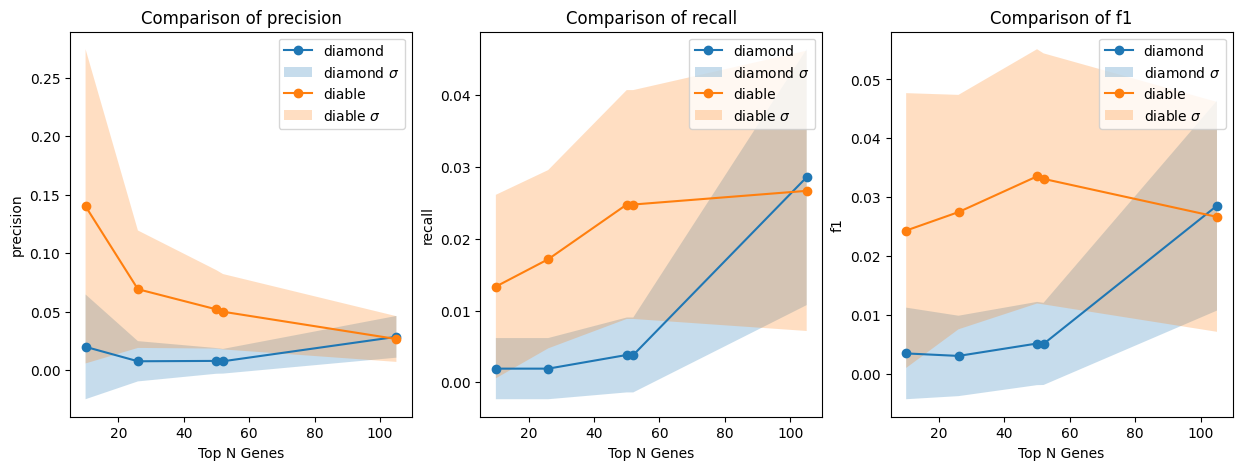

In [224]:
fig, ax = plot_diamond_diable(means, stds, ["precision", "recall", "f1"])

In [227]:
diffusion_result = pd.read_csv("metrics/cv_diffusion.csv", index_col=None)
diffusion_means = diffusion_result.groupby(["num_genes", "time"]).mean().reset_index()
diffusion_means["algorithm"] = list(map(lambda time: f"time={time}", diffusion_means.time))

diffusion_stds = diffusion_result.groupby(["num_genes", "time"]).std().reset_index()
diffusion_stds["algorithm"] = list(map(lambda time: f"time={time}", diffusion_means.time))

(<Figure size 1500x500 with 3 Axes>,
 <Axes: title={'center': 'Comparison of f1'}, xlabel='Top N Genes', ylabel='f1'>)

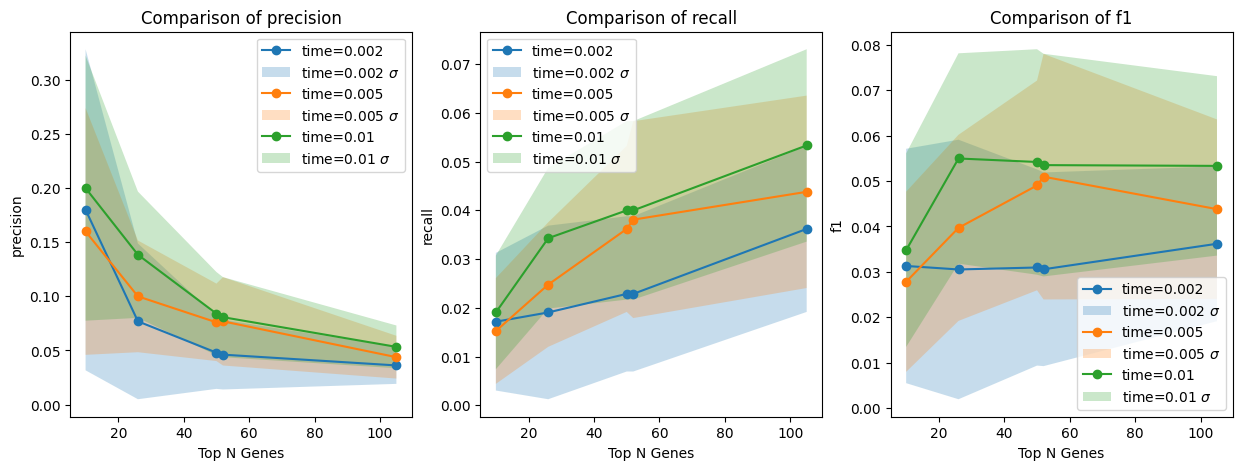

In [228]:
plot_diamond_diable(diffusion_means, diffusion_stds, ["precision", "recall", "f1"])